In [ ]:
# Install RDKit. Takes 2-3 minutes
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

!conda install -y -c deepchem -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import tensorflow as tf

!git clone https://github.com/deepchem/deepchem.git
%cd deepchem/
!python setup.py install
import deepchem as dc

# Loading Data


In [ ]:
import numpy as np
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21() #(featurizer='GraphConv', reload=False)
dataset = tox21_datasets


In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd ../drive/My\ Drive/Colab_Notebooks/DeepChem
#%cd Colab_Notebooks/DeepChem/

In [ ]:
dataset_file = "tox21.csv"
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=tox21_tasks, smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)

In [9]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)

# Creating and Training the Model

In [10]:
import numpy as np
import numpy.random
import deepchem as dc
np.random.seed(123)

optimizer = dc.hyper.GridHyperparamOpt(
    lambda **params: dc.models.MultitaskClassifier(n_tasks=12,
                                                  n_features=1024, **params))

#dropouts=[0.], weight_init_stddevs=[np.sqrt(6) / np.sqrt(1000)],learning_rate=0.003, 

params_dict = {"batch_size": [10, 20]}
transformers = []
metric = dc.metrics.Metric(
    dc.metrics.roc_auc_score, task_averager=np.mean)

best_model, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict,
    train_dataset,
    valid_dataset,
    transformers,
    metric,
    use_max=False)

valid_score = best_model.evaluate(valid_dataset, [metric])

Epoch 0 loss: 0.057868
Epoch 1 loss: 0.051289
Epoch 2 loss: 0.041087
Epoch 3 loss: 0.045939
Epoch 4 loss: 0.046518
Epoch 5 loss: 0.043015
Epoch 6 loss: 0.032216
Epoch 7 loss: 0.038398
Epoch 8 loss: 0.007837
Epoch 9 loss: 0.034018


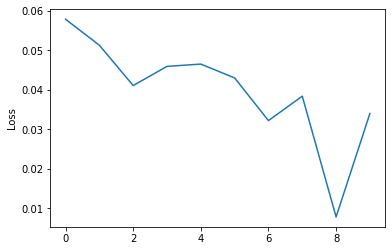

In [12]:
#model = dc.models.MultitaskClassifier(n_tasks = 12, n_features=1024, layer_sizes=[1000])

num_epochs = 10
losses = []
for i in range(num_epochs):
 loss = best_model.fit(train_dataset, nb_epoch=1)
 print("Epoch %d loss: %f" % (i, loss))
 losses.append(loss)

import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('Loss')
plt.show()

# Evaluating the Model

In [13]:
import numpy as np
#metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

train_scores = best_model.evaluate(train_dataset, [metric], transformers)
print("Training ROC AUC Score: %f" % train_scores["mean-roc_auc_score"])
valid_scores = best_model.evaluate(valid_dataset, [metric], transformers)
print("Validation ROC AUC Score: %f" % valid_scores["mean-roc_auc_score"])

Training ROC AUC Score: 0.994588
Validation ROC AUC Score: 0.769029


# LIME for interpretablity

In [ ]:
!pip install lime
from lime import lime_tabular
feature_names = ["fp_%s"  % x for x in range(1024)]
explainer = lime_tabular.LimeTabularExplainer(train_dataset.X, 
                                              feature_names=feature_names, 
                                              categorical_features=feature_names,
                                              class_names=['not toxic', 'toxic'], 
                                              )

In [16]:
# We need a function which takes a 2d numpy array (samples, features) and returns predictions (samples,)
def eval_model(my_model):
    def eval_closure(x):
        ds = dc.data.NumpyDataset(x, n_tasks=12)
        # The 0th task is NR-AR
        predictions = my_model.predict(ds)[:,0]
        return predictions
    return eval_closure
model_fn = eval_model(best_model)

#Using the Model to predict Toxicities 

In [31]:
def show_predictions(numSamples):
  for i in range(0,numSamples):
    active_id = np.where(train_dataset.y[:,0]==1)[0][i]
    print(active_id)
    exp = explainer.explain_instance(train_dataset.X[active_id], model_fn, num_features=5, top_labels=1) 
    exp.show_in_notebook(show_table=True, show_all=False)
    Chem.MolFromSmiles(train_dataset.ids[active_id])

def show_samples(list): 
  if len(list) <= 15: 
    print('There are %d samples, showing all of them'% len(list))
    show_predictions(len(list))
  else:
    print('There are %d samples, showing 15 of them'% len(list))
    show_predictions(15)

In [ ]:
# Imaging imports to get pictures in the notebook
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# We want to investigate a toxic compound
n = np.where(train_dataset.y[:,0]==1)[0]
show_samples(n)